In [ ]:
import torch
import numpy as np
from PIL import Image
from scipy.signal import convolve
from torchvision import transforms
import matplotlib.pyplot as plot

# 二维离散傅立叶变换与反变换
$$
F(u,v)=\sum_{x=0}^{M-1}\sum_{y=0}^{N-1}f(x,y)\cdot e^{-2\pi j(\frac{xu}{M}+\frac{yv}{N})},u\in\{1,2,\cdots M\}\,and\,v\in\{1,2,\cdots N\}
$$
- 等价两次一维傅立叶变换，先对行作傅立叶变换，再对列作傅立叶变换 $F(u,v)=\sum_{x=0}^{M-1}\left[\sum_{y=0}^{N-1}f(x,y)\cdot e^{-2\pi j(\frac{vy}{N})}\right]\cdot e^{-2\pi j(\frac{ux}{M})}$
$$
f(x,y)=\frac{1}{M\cdot N}\sum_{u=0}^{M-1}\sum_{v=0}^{N-1}F(u,v)\cdot e^{2\pi j(\frac{ux}{M}+\frac{vy}{N})},x\in\{1,2,\cdots M\}\,and\,y\in\{1,2,\cdots N\}
$$
- 等价两次一维傅立叶变换，先对行作傅立叶变换，再对列作傅立叶变换 $f(x,y)=\frac{1}{M}\sum_{u=0}^{M-1}\left[\frac{1}{N}\sum_{v=0}^{N-1}F(u,v)\cdot e^{2\pi j(\frac{vy}{N})}\right]\cdot e^{2\pi j(\frac{ux}{M})}$


In [2]:
def dft2d_dotloop(inputs):
    m, n = inputs.shape
    result = np.zeros((m, n), dtype=np.complex64)
    for u in range(m):
        for v in range(n):
            for x in range(m):
                for y in range(n):
                    result[u, v] += inputs[x, y] * np.exp(-2j * np.pi * (((x * u) / m) + ((y * v) / n)))

    return result

def idft2d_dotloop(inputs):
    m, n = inputs.shape
    result = np.zeros((m, n), dtype=np.complex64)
    for x in range(m):
        for y in range(n):
            for u in range(m):
                for v in range(n):
                    result[x, y] += inputs[u, v] * np.exp(2j * np.pi * (((u * x) / m) + ((v * y) / n)))
    result /= (m*n)

    return result

a = np.array([[1, 1, 3, 5], [1, 1, 1, 1], [1, 1, 2, 1], [1, 1, 1, 1]])
b = np.random.randn(4, 4)

print(a,
      dft2d_dotloop(a),
      np.fft.fft2(a),
      np.abs(idft2d_dotloop(dft2d_dotloop(a))),
      dft2d_dotloop(a)-np.fft.fft2(a), 
      idft2d_dotloop(dft2d_dotloop(a))-a, sep="\n")
print(b,
      dft2d_dotloop(b),
      np.fft.fft2(b),
      idft2d_dotloop(dft2d_dotloop(b)),
      dft2d_dotloop(b)-np.fft.fft2(b), 
      idft2d_dotloop(dft2d_dotloop(b))-a, sep="\n")

[[1 1 3 5]
 [1 1 1 1]
 [1 1 2 1]
 [1 1 1 1]]
[[23.+0.0000000e+00j -3.+4.0000000e+00j -1.-1.7145056e-15j
  -3.-4.0000000e+00j]
 [ 5.+0.0000000e+00j -1.+4.0000000e+00j -3.+0.0000000e+00j
  -1.-4.0000000e+00j]
 [ 7.-7.3478811e-16j -3.+4.0000000e+00j -1.-4.8985874e-16j
  -3.-4.0000000e+00j]
 [ 5.+0.0000000e+00j -1.+4.0000000e+00j -3.+0.0000000e+00j
  -1.-4.0000000e+00j]]
[[23.+0.j -3.+4.j -1.+0.j -3.-4.j]
 [ 5.+0.j -1.+4.j -3.+0.j -1.-4.j]
 [ 7.+0.j -3.+4.j -1.+0.j -3.-4.j]
 [ 5.+0.j -1.+4.j -3.+0.j -1.-4.j]]
[[1. 1. 3. 5.]
 [1. 1. 1. 1.]
 [1. 1. 2. 1.]
 [1. 1. 1. 1.]]
[[0.+0.00000000e+00j 0.+0.00000000e+00j 0.-1.71450565e-15j
  0.+0.00000000e+00j]
 [0.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j
  0.+0.00000000e+00j]
 [0.-7.34788112e-16j 0.+0.00000000e+00j 0.-4.89858741e-16j
  0.+0.00000000e+00j]
 [0.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j
  0.+0.00000000e+00j]]
[[0.+0.00000000e+00j 0.+4.16333634e-17j 0.-2.77555756e-17j
  0.-1.38777878e-16j]
 [0.+4.16333634e-17j 0

In [3]:
def dft2d_vectorloop(inputs):
    m, n = inputs.shape
    temp = np.zeros((m, n), dtype=np.complex64)
    result = np.zeros((m, n), dtype=np.complex64)
    for v in range(n):
        for y in range(n):
            temp[:, v] += inputs[:, y] * np.exp(-2j * np.pi * ((y * v) / n))
    for u in range(m):    
        for x in range(m):      
            result[u, :] += temp[x, :] * np.exp(-2j * np.pi * ((x * u) / m))

    return result

def idft2d_vectorloop(inputs):
    m, n = inputs.shape
    temp = np.zeros((m, n), dtype=np.complex64)
    result = np.zeros((m, n), dtype=np.complex64)
    for y in range(n):
        for v in range(n):
            temp[:, y] += inputs[:, v] * np.exp(2j * np.pi * ((v * y) / n))
    temp /= n 
    for x in range(m):    
        for u in range(m):      
            result[x, :] += temp[u, :] * np.exp(2j * np.pi * ((u * x) / m))
    result /= m 

    return result

a = np.array([[1, 1, 3, 5], [1, 1, 1, 1], [1, 1, 2, 1], [1, 1, 1, 1]])
b = np.random.randn(4, 4)

print(a,
      dft2d_vectorloop(a),
      np.fft.fft2(a),
      np.abs(idft2d_vectorloop(dft2d_vectorloop(a))),
      dft2d_vectorloop(a)-np.fft.fft2(a), 
      idft2d_vectorloop(dft2d_vectorloop(a))-a, sep="\n")
print(b,
      dft2d_vectorloop(b),
      np.fft.fft2(b),
      idft2d_vectorloop(dft2d_vectorloop(b)),
      dft2d_vectorloop(b)-np.fft.fft2(b), 
      idft2d_vectorloop(dft2d_vectorloop(b))-a, sep="\n")

[[1 1 3 5]
 [1 1 1 1]
 [1 1 2 1]
 [1 1 1 1]]
[[23.+0.0000000e+00j -3.+4.0000000e+00j -1.-1.7145054e-15j
  -3.-4.0000000e+00j]
 [ 5.+0.0000000e+00j -1.+4.0000000e+00j -3.-1.3471115e-15j
  -1.-4.0000000e+00j]
 [ 7.-7.3478806e-16j -3.+4.0000000e+00j -1.-4.8985874e-16j
  -3.-4.0000000e+00j]
 [ 5.+0.0000000e+00j -1.+4.0000000e+00j -3.-1.5920408e-15j
  -1.-4.0000000e+00j]]
[[23.+0.j -3.+4.j -1.+0.j -3.-4.j]
 [ 5.+0.j -1.+4.j -3.+0.j -1.-4.j]
 [ 7.+0.j -3.+4.j -1.+0.j -3.-4.j]
 [ 5.+0.j -1.+4.j -3.+0.j -1.-4.j]]
[[1. 1. 3. 5.]
 [1. 1. 1. 1.]
 [1. 1. 2. 1.]
 [1. 1. 1. 1.]]
[[0.+0.00000000e+00j 0.+0.00000000e+00j 0.-1.71450543e-15j
  0.+0.00000000e+00j]
 [0.+0.00000000e+00j 0.+0.00000000e+00j 0.-1.34711146e-15j
  0.+0.00000000e+00j]
 [0.-7.34788059e-16j 0.+0.00000000e+00j 0.-4.89858741e-16j
  0.+0.00000000e+00j]
 [0.+0.00000000e+00j 0.+0.00000000e+00j 0.-1.59204078e-15j
  0.+0.00000000e+00j]]
[[0.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j
  0.+0.00000000e+00j]
 [0.+0.00000000e+00j 0

# 频域卷积定理
$$
\mathcal{F^{-1}}\{\mathcal{F}(a)\ast\mathcal{F}(b)\}=a\star b

In [4]:
# 构造数据
a = torch.arange(0,9,1).reshape(3,3).type(torch.float32)
b = torch.arange(1,10,1).reshape(3,3).type(torch.float32)
c = torch.arange(9,0,-1).reshape(3,3).type(torch.float32)
pad_size = 100
a_pad = torch.nn.functional.pad(a, [pad_size]*4, value=0)
b_pad = torch.nn.functional.pad(b, [pad_size]*4, value=0)

print(f"a:\n{a}\na {a.shape}", f"b:\n{b}\nb {b.shape}", f"c:\n{c}\nc {c.shape}",
      f"a_pad_centre:\n{a_pad[pad_size:pad_size+3, pad_size:pad_size+3]}\na_pad {a_pad.shape}",
      f"b_pad_centre:\n{b_pad[pad_size:pad_size+3, pad_size:pad_size+3]}\nb_pad {b_pad.shape}", sep="\n")

"""
通过
b = torch.fft.fftshift(torch.fft.fft2(a))
c = torch.fft.ifftshift(torch.fft.ifft2(b.conj()))
得a的中心对称c
或者
b = torch.fft.fft2(a)
c = torch.fft.ifftshift(torch.fft.ifft2(b.conj()))
幅度对但相位错
"""

a:
tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])
a torch.Size([3, 3])
b:
tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])
b torch.Size([3, 3])
c:
tensor([[9., 8., 7.],
        [6., 5., 4.],
        [3., 2., 1.]])
c torch.Size([3, 3])
a_pad_centre:
tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])
a_pad torch.Size([203, 203])
b_pad_centre:
tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])
b_pad torch.Size([203, 203])


In [5]:
# 空域卷积
result = convolve(a, b, 'same')
result_ab = torch.conv2d(a.unsqueeze(0).unsqueeze(0), b.unsqueeze(0).unsqueeze(0), padding=1).squeeze(0).squeeze(0)
result_ac = torch.conv2d(a.unsqueeze(0).unsqueeze(0), c.unsqueeze(0).unsqueeze(0), padding=1).squeeze(0).squeeze(0)

print(f"signal-convolve(ab):\n{result}\nis real convolution operation",
      f"pytorch-conv2d(ab):\n{result_ab}\nis noly correlation operation",
      f"pytorch-conv2d(ac):\n{result_ac}\ncorrelation equal real convolution after inverter kernel", sep="\n")

signal-convolve(ab):
[[ 14.  35.  38.]
 [ 57. 120. 111.]
 [110. 197. 158.]]
is real convolution operation
pytorch-conv2d(ab):
tensor([[ 66., 115.,  82.],
        [153., 240., 159.],
        [ 90., 133.,  82.]])
is noly correlation operation
pytorch-conv2d(ac):
tensor([[ 14.,  35.,  38.],
        [ 57., 120., 111.],
        [110., 197., 158.]])
correlation equal real convolution after inverter kernel


In [6]:
# 测试傅立叶变换与反变换是否可逆
a_k1 = torch.fft.fft2(a)
b_k1 = torch.fft.fft2(b)
a_k2 = torch.fft.fftshift(torch.fft.fft2(a))
b_k2 = torch.fft.fftshift(torch.fft.fft2(b))
a_k3 = torch.fft.fft2(torch.fft.fftshift(a))
b_k3 = torch.fft.fft2(torch.fft.fftshift(b))
a_pad_k1 = torch.fft.fft2(a_pad)
b_pad_k1 = torch.fft.fft2(b_pad)
a_pad_k2 = torch.fft.fftshift(torch.fft.fft2(a_pad))
b_pad_k2 = torch.fft.fftshift(torch.fft.fft2(b_pad))
a_pad_k3 = torch.fft.fft2(torch.fft.fftshift(a_pad))
b_pad_k3 = torch.fft.fft2(torch.fft.fftshift(b_pad))

print(f"1.a-fft-ifft:\n{torch.fft.ifft2(a_k1)}\nis right reversible operation",
      f"2.a-fft-ifft-ifftshift:\n{torch.fft.ifftshift(torch.fft.ifft2(a_k1))}\nneed use fftshift and ifftshift operation in pairs",
      f"3.a-fft-ifftshift-ifft:\n{torch.fft.ifft2(torch.fft.ifftshift(a_k1))}\namplitude is right but phase is wrong",
      f"4.a-fft-fftshift-ifft-ifftshift:\n{torch.fft.ifftshift(torch.fft.ifft2(a_k2))}\nis wrong operation",
      f"5.a-fft-fftshift-ifftshift-ifft:\n{torch.fft.ifft2(torch.fft.ifftshift(a_k2))}\nis right reversible operation",
      f"6.a-fft-fftshift-ifft:\n{torch.fft.ifft2(a_k2)}\namplitude is right but phase is wrong",
      f"7.a-fftshift-fft-ifft-ifftshift:\n{torch.fft.ifftshift(torch.fft.ifft2(a_k3))}\nis wrong operation",
      f"8.a-fftshift-fft-ifftshift-ifft:\n{torch.fft.ifft2(torch.fft.ifftshift(a_k3))}\nis wrong operation",
      f"9.a-fftshift-fft-ifft:\n{torch.fft.ifft2(a_k3)}\nis wrong operation", sep="\n")
      
"""     
结论: 
1.fft与ifft是一组可逆操作
2.平移fftshift通常使得低频在中心高频在四周是为了分析频谱图
3.理论上[可通过fourier变换平移定理先把原始图像做变换再做fft]或者[先做fft后再根据频域图像的对称性做对称变换]
4.fftshift和逆平移ifftshift是后一种直接在频域上进行移动
5.错误的fftshift和逆平移ifftshift使用顺序会导致结果出错
""" 

1.a-fft-ifft:
tensor([[0.+0.j, 1.+0.j, 2.+0.j],
        [3.+0.j, 4.+0.j, 5.+0.j],
        [6.+0.j, 7.+0.j, 8.+0.j]])
is right reversible operation
2.a-fft-ifft-ifftshift:
tensor([[4.+0.j, 5.+0.j, 3.+0.j],
        [7.+0.j, 8.+0.j, 6.+0.j],
        [1.+0.j, 2.+0.j, 0.+0.j]])
need use fftshift and ifftshift operation in pairs
3.a-fft-ifftshift-ifft:
tensor([[ 0.0000+0.0000e+00j, -0.5000-8.6603e-01j, -1.0000+1.7321e+00j],
        [-1.5000-2.5981e+00j, -2.0000+3.4641e+00j,  5.0000+0.0000e+00j],
        [-3.0000+5.1962e+00j,  7.0000-2.3842e-07j, -4.0000-6.9282e+00j]])
amplitude is right but phase is wrong
4.a-fft-fftshift-ifft-ifftshift:
tensor([[-2.0000-3.4641e+00j,  5.0000+0.0000e+00j, -1.5000+2.5981e+00j],
        [ 7.0000+2.3842e-07j, -4.0000+6.9282e+00j, -3.0000-5.1962e+00j],
        [-0.5000+8.6603e-01j, -1.0000-1.7321e+00j,  0.0000+0.0000e+00j]])
is wrong operation
5.a-fft-fftshift-ifftshift-ifft:
tensor([[0.+0.j, 1.+0.j, 2.+0.j],
        [3.+0.j, 4.+0.j, 5.+0.j],
        [6.+0.j, 7.+

'     \n结论: \n1.fft与ifft是一组可逆操作\n2.平移目的是方便分析频谱图是的低频在中心高频在四周\n  可通过fourier变换平移定理先把原始图像做变换再做fft或先做fft后再根据频域图像的对称性做对称变换\n  通常fftshift和逆平移ifftshift是后种因此应在频域成对使用\n3.频谱顺序发生变化后再ifft结果幅度不变但是相位改变\n'

In [7]:
# 测试频域卷积定理
result_k1 = a_k1 * b_k1
result_k2 = a_k2 * b_k2
result_k3 = a_k3 * b_k3
result_pad_k1 = a_pad_k1 * b_pad_k1
result_pad_k2 = a_pad_k2 * b_pad_k2
result_pad_k3 = a_pad_k3 * b_pad_k3


print(
      f"1.result-fft-(ab)-ifft:\n{torch.fft.ifft2(result_k1)}",
      f"2.result-fft-(ab)-ifftshift-ifft:\n{torch.fft.ifft2(torch.fft.ifftshift(result_k1))}",
      f"3.result-fft-(ab)-ifft-ifftshift:\n{torch.fft.ifftshift(torch.fft.ifft2(result_k1))}",
      f"4.result-fft-fftshift-(ab)-ifft:\n{torch.fft.ifft2(result_k2)}",
      f"5.result-fft-fftshift-(ab)-ifftshift-ifft:\n{torch.fft.ifft2(torch.fft.ifftshift(result_k2))}",
      f"6.result-fft-fftshift-(ab)-ifft-ifftshift:\n{torch.fft.ifftshift(torch.fft.ifft2(result_k2))}",
      f"7.result-fftshift-fft-(ab)-ifft:\n{torch.fft.ifft2(result_k3)}",
      f"8.result-fftshift-fft-(ab)-ifftshift-ifft:\n{torch.fft.ifft2(torch.fft.ifftshift(result_k3))}",
      f"9.result-fftshift-fft-(ab)-ifft-ifftshift:\n{torch.fft.ifftshift(torch.fft.ifft2(result_k3))}",
      "all is wrong that should be due to the lack of frequency domain accuracy", sep="\n"
)

print(
      "对空域原始图像进行补零提高频域精度",
      f"1.result_pad-fft-(ab)-ifft:\n{torch.fft.ifft2(result_pad_k1)[pad_size:pad_size+3, pad_size:pad_size+3]}",
      f"2.result_pad-fft-(ab)-ifftshift-ifft:\n{torch.fft.ifft2(torch.fft.ifftshift(result_pad_k1))[pad_size:pad_size+3, pad_size:pad_size+3]}",
      f"3.result_pad-fft-(ab)-ifft-ifftshift:\n{torch.fft.ifftshift(torch.fft.ifft2(result_pad_k1))[pad_size:pad_size+3, pad_size:pad_size+3]}",
      f"4.result_pad-fft-fftshift-(ab)-ifft:\n{torch.fft.ifft2(result_pad_k2)[pad_size:pad_size+3, pad_size:pad_size+3]}",
      f"5.result_pad-fft-fftshift-(ab)-ifftshift-ifft:\n{torch.fft.ifft2(torch.fft.ifftshift(result_pad_k2))[pad_size:pad_size+3, pad_size:pad_size+3]}",
      f"6.result_pad-fft-fftshift-(ab)-ifft-ifftshift:\n{torch.fft.ifftshift(torch.fft.ifft2(result_pad_k2))[pad_size:pad_size+3, pad_size:pad_size+3]}",
      f"7.result_pad-fftshift-fft-(ab)-ifft:\n{torch.fft.ifft2(result_pad_k3)[pad_size:pad_size+3, pad_size:pad_size+3]}",
      f"8.result_pad-fftshift-fft-(ab)-ifftshift-ifft:\n{torch.fft.ifft2(torch.fft.ifftshift(result_pad_k3))[pad_size:pad_size+3, pad_size:pad_size+3]}",
      f"9.result_pad-fftshift-fft-(ab)-ifft-ifftshift:\n{torch.fft.ifftshift(torch.fft.ifft2(result_pad_k3))[pad_size:pad_size+3, pad_size:pad_size+3]}",
      "only 3 is right operation and 6 amplitude is right but phase is wrong", sep="\n"
)

"""     
结论: 
1.频域卷积定理实现时需要提高频域精度
2.频域卷积定理实现的严格操作顺序:[先进行傅立叶变换fft,接着进行频域点乘,然后进行傅立叶反变换ifft,最后进行平移ifftshift]
""" 

1.result-fft-(ab)-ifft:
tensor([[210.+0.j, 210.+0.j, 201.+0.j],
        [210.+0.j, 210.+0.j, 201.+0.j],
        [129.+0.j, 129.+0.j, 120.+0.j]])
2.result-fft-(ab)-ifftshift-ifft:
tensor([[ 210.0000+0.0000e+00j, -105.0000-1.8187e+02j, -100.5000+1.7407e+02j],
        [-105.0000-1.8187e+02j, -105.0000+1.8187e+02j,  201.0000+7.6294e-06j],
        [ -64.5000+1.1172e+02j,  129.0000+3.8147e-06j,  -60.0000-1.0392e+02j]])
3.result-fft-(ab)-ifft-ifftshift:
tensor([[210.+0.j, 201.+0.j, 210.+0.j],
        [129.+0.j, 120.+0.j, 129.+0.j],
        [210.+0.j, 201.+0.j, 210.+0.j]])
4.result-fft-fftshift-(ab)-ifft:
tensor([[ 210.0000+0.0000e+00j, -105.0000+1.8187e+02j, -100.5000-1.7407e+02j],
        [-105.0000+1.8187e+02j, -105.0000-1.8187e+02j,  201.0000-7.6294e-06j],
        [ -64.5000-1.1172e+02j,  129.0000-3.8147e-06j,  -60.0000+1.0392e+02j]])
5.result-fft-fftshift-(ab)-ifftshift-ifft:
tensor([[210.+0.j, 210.+0.j, 201.+0.j],
        [210.+0.j, 210.+0.j, 201.+0.j],
        [129.+0.j, 129.+0.j, 120.+

'     \n结论: \n1.频域卷积定理实现时需要提高频域精度\n2.频域卷积定理实现的严格操作顺序:[先进行傅立叶变换fft,接着进行频域点乘,然后进行傅立叶反变换ifft,最后进行平移ifftshift]\n'

# 实践

In [57]:
# 加载图像
path = r'/Users/WangHao/工作/纳米光子中心/全光相关/实验-0303/0303.png'
img = Image.open(path).convert('L')
img = transforms.Compose([transforms.ToTensor(), transforms.Resize((201, 201))])(img)
img = img.squeeze(0)

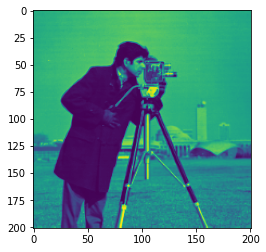

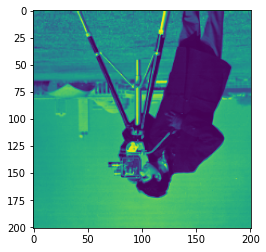

In [58]:
img_k = torch.fft.fft2(img)
# 傅立叶变换与逆变换
img_1 = torch.fft.ifft2(img_k)
# 连续两次傅立叶变换等价原图中心对称
img_2 = torch.fft.fft2(img_k)
plot.figure(1)
plot.imshow(img_1.abs())
plot.figure(2)
plot.imshow(img_2.abs())

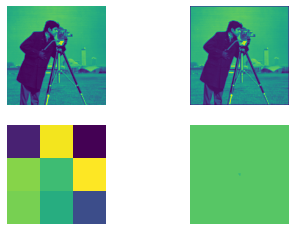

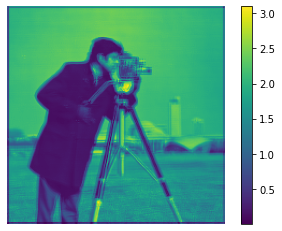

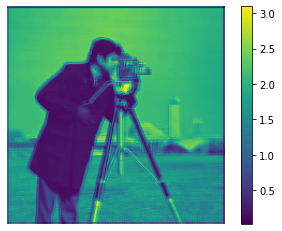

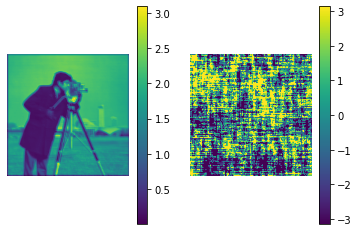

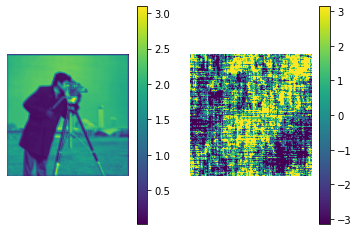

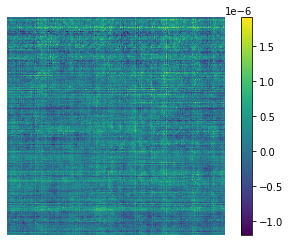

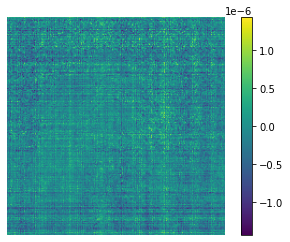

In [73]:
# 比较空域卷积与频域卷积
a = torch.arange(1,10,1).reshape(3,3).float()
a = torch.tensor([[1. ,1 ,1], [1 ,-8 ,1], [1 ,1 ,1]])
a = torch.rand(3,3)
a = torch.randn(3,3)

img_1 = torch.nn.functional.pad(img, [1,1,1,1], value=0)
img_k_1 = torch.fft.fft2(img_1)
b = torch.nn.functional.pad(a, [100,100,100,100], value=0)
b_k_1 = torch.fft.fft2(b)
b_k_1_conj = torch.fft.fft2(b.reshape(-1).flipud().reshape(203, 203))

# 卷积运算
result1 = torch.tensor(convolve(img_1, a, 'same'))
# 相关运算
result2 = torch.conv2d(img_1.unsqueeze(0).unsqueeze(0), a.unsqueeze(0).unsqueeze(0), padding=1).squeeze(0).squeeze(0)
# 卷积运算
result3 = torch.fft.ifftshift(torch.fft.ifft2(img_k_1 * b_k_1))
# 相关运算
result4 = torch.fft.ifftshift(torch.fft.ifft2(img_k_1 * b_k_1_conj))

error1 = result1.abs() - result3.abs()
error2 = result2.abs() - result4.abs()

plot.figure(0)
plot.subplot(221)
plot.imshow(img)
plot.axis("off")
plot.subplot(222)
plot.imshow(img_1)
plot.axis("off")
plot.subplot(223)
plot.imshow(a)
plot.axis("off")
plot.subplot(224)
plot.imshow(b)
plot.axis("off")

plot.figure(1)
plot.imshow(result1.abs())
plot.axis("off")
plot.colorbar()
plot.figure(2)
plot.imshow(result2.abs())
plot.axis("off")
plot.colorbar()

plot.figure(3)
plot.subplot(121)
plot.imshow(result3.abs())
plot.axis("off")
plot.colorbar()
plot.subplot(122)
plot.imshow(result3.angle())
plot.axis("off")
plot.colorbar()

plot.figure(4)
plot.subplot(121)
plot.imshow(result4.abs())
plot.axis("off")
plot.colorbar()
plot.subplot(122)
plot.imshow(result4.angle())
plot.axis("off")
plot.colorbar()

plot.figure(5)
plot.imshow(error1)
plot.axis("off")
plot.colorbar()
plot.figure(6)
plot.imshow(error2)
plot.axis("off")
plot.colorbar()

"""
结论:
1.通过傅立叶变换在频域可以实现卷积运算即频域卷积
2.进行频域卷积时至少需要补一圈零否则边界上会与空域卷积（空域卷积为了保证大小通常都会补零）不匹配
"""